# Bio 724: Pandas example application

## Libraries

In [2]:
import itertools

import pandas as pd
# see https://pandas.pydata.org/docs/user_guide/copy_on_write.html#
pd.options.mode.copy_on_write = True

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import image

import skimage

## Biological context

We're going to illustrate using Pandas to facilitate an image based analysis of a biological experiment.

The examples illustrated below are from a study that the Magwene lab is carrying out to understand the genetic architecture of a cellular phenotype called ["Titan cell formation"](https://pmc.ncbi.nlm.nih.gov/articles/PMC3723695/) in the fungal pathogen, *Cryptococcus neoformans*.  Titan cells are giant cells that form when *C. neoformans* is exposed to conditions that mimic the lung epithelial environment. These giant cells are thought to contribute to pathogenesis because they are more likely to escape phagocytosis by host macrophages.  

The data below come from a chemical genetic analysis in the Magwene lab to explore how variation in the cAMP-PKA signaling pathway contributes to variation in titan cell formation.  The images below contrast differences in cellular phenotypes when a particular strain is exposed to the standard titan cell inducing conditions (`CONTROL` treatment) or to titan-inducing conditions plus the addition of IBMX (a phosphodiesterase inhibitor).


## Metadata and DataFrame creation

In [3]:
# Create metadata for our analyses

strains = ["PMY2279"]
treatments = ["CONTROL", "IBMX-2mM"]
rep = ["A", "B"]
imgtype = ["gray", "mask"]


metadata = list(itertools.product(strains, treatments, imgtype, rep))
metadata

[('PMY2279', 'CONTROL', 'gray', 'A'),
 ('PMY2279', 'CONTROL', 'gray', 'B'),
 ('PMY2279', 'CONTROL', 'mask', 'A'),
 ('PMY2279', 'CONTROL', 'mask', 'B'),
 ('PMY2279', 'IBMX-2mM', 'gray', 'A'),
 ('PMY2279', 'IBMX-2mM', 'gray', 'B'),
 ('PMY2279', 'IBMX-2mM', 'mask', 'A'),
 ('PMY2279', 'IBMX-2mM', 'mask', 'B')]

In [4]:
# filenames of images to read based on metadata above

filenames = [f"{strain}_{treatment}_{rep}_{imgtype}.jpg" for (strain, treatment, imgtype, rep) in metadata]
filenames

['PMY2279_CONTROL_A_gray.jpg',
 'PMY2279_CONTROL_B_gray.jpg',
 'PMY2279_CONTROL_A_mask.jpg',
 'PMY2279_CONTROL_B_mask.jpg',
 'PMY2279_IBMX-2mM_A_gray.jpg',
 'PMY2279_IBMX-2mM_B_gray.jpg',
 'PMY2279_IBMX-2mM_A_mask.jpg',
 'PMY2279_IBMX-2mM_B_mask.jpg']

In [5]:
# Create a data frame holding metadata, filenames, and image arrays

df = pd.DataFrame({
    'strain': [i[0] for i in metadata],
    'treatment': [i[1] for i in metadata],
    'imgtype': [i[2] for i in metadata],
    'rep': [i[3] for i in metadata],    
    'file': filenames,
    'image': [image.imread(f) for f in filenames]
})

df.head()

,strain,treatment,imgtype,rep,file,image
0,PMY2279,CONTROL,gray,A,PMY2279_CONTROL_A_gray.jpg,"[[[134, 134, 134], [133, 133, 133], [137, 137,..."
1,PMY2279,CONTROL,gray,B,PMY2279_CONTROL_B_gray.jpg,"[[[137, 137, 137], [135, 135, 135], [133, 133,..."
2,PMY2279,CONTROL,mask,A,PMY2279_CONTROL_A_mask.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,PMY2279,CONTROL,mask,B,PMY2279_CONTROL_B_mask.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,PMY2279,IBMX-2mM,gray,A,PMY2279_IBMX-2mM_A_gray.jpg,"[[[130, 130, 130], [131, 131, 131], [133, 133,..."


## Looking at the image data

Before we get into quantitative analyses, let's take a moment to look at the images that represent the raw data.

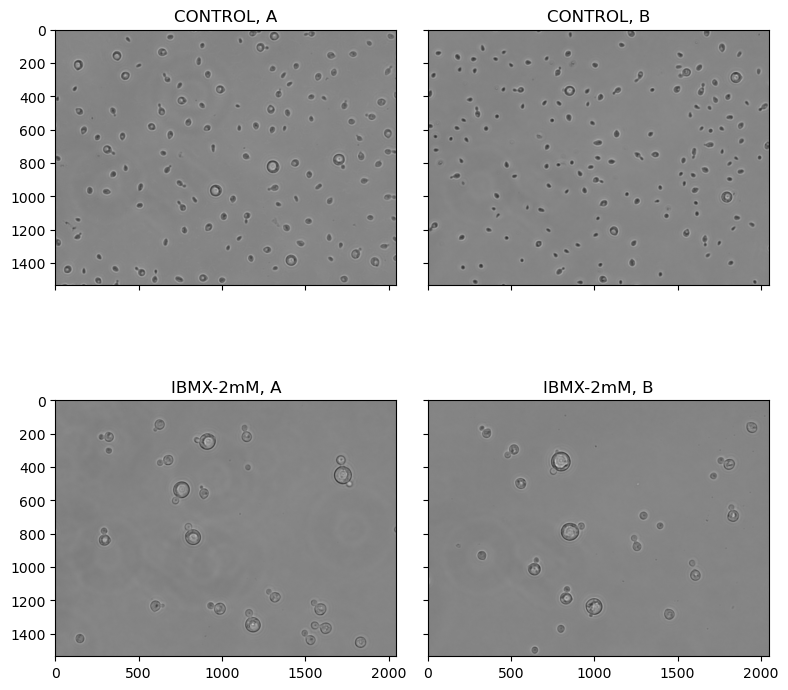

In [6]:
# plot the grayscale images 


fig, axes = plt.subplots(nrows = 2, ncols = 2,
                        sharex = True, sharey = True,
                        figsize = (8,8))


# iterating over rows of a data frame is usually considered inefficient
# if you're doing computations that can be expressed in vectorized form
# but for this plotting application it's a decent solution

gray_df = df[df["imgtype"] == "gray"]

ct = 0
for (idx, row) in gray_df.iterrows():
    ax = axes[ct // 2, ct % 2]
    ax.imshow(row["image"])
    ax.set_title(f'{row["treatment"]}, {row["rep"]}')
    ct += 1

plt.tight_layout()
    

### Segmentation masks

Now let's look at the segmented masks for these images which were created in ImageJ. Segmentation is the process of finding objects of interest in images.

We could carry out such a segmentation in Python, using Scikit-Image or other libraries, but for simplicity we'll use the already existing masks 



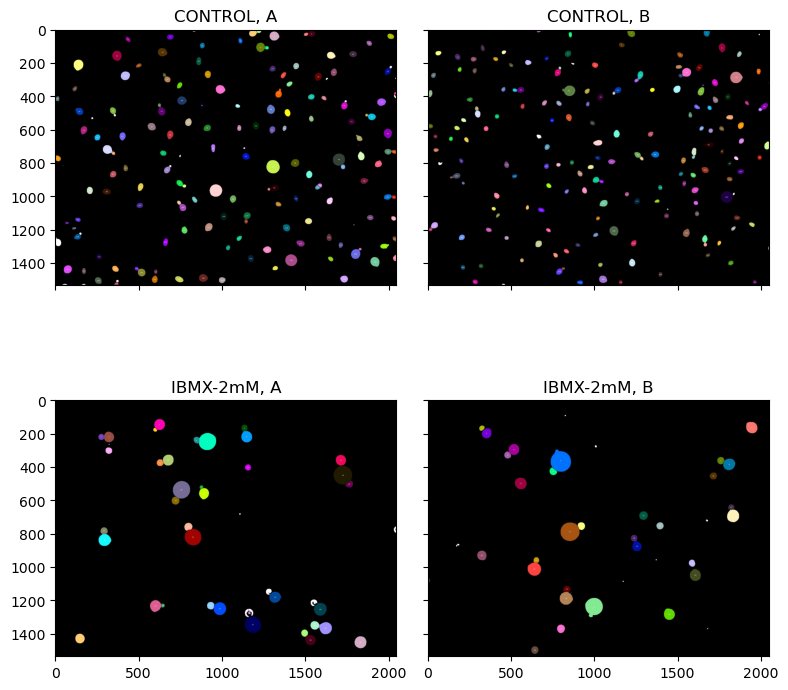

In [6]:

# Mask data

fig, axes = plt.subplots(nrows = 2, ncols = 2,
                        sharex = True, sharey = True,
                        figsize = (8,8))


mask_df = df[df["imgtype"] == "mask"]

ct = 0
for (idx, row) in mask_df.iterrows():
    ax = axes[ct // 2, ct % 2]
    ax.imshow(row["image"])
    ax.set_title(f'{row["treatment"]}, {row["rep"]}')
    ct += 1

plt.tight_layout()

# Masks to labeled arrays

Our next step involves turning the masks into labeled arrays we can use to measure properties of interest on each of the segemented cells.

We'll write functions to carry out these steps so we can apply them easily to multiple rows.

In [7]:
def mask2labeled(rgbmask, threshold = 25):
    """Convert an RGB mask to a segmented and labeled array
    """
    # the masks are rgb images
    # we sum across the RGB layers (axis = 2), and threshold
    masksum = rgbmask.sum(axis = 2)  
    binary = masksum >= 25
    lblimg = skimage.measure.label(binary)
    return lblimg
    

def labeled_properties_df(lblimg, properties=["label", "centroid", "area", "feret_diameter_max"]):
    """From a labeled array, calculate various properties of the segmented objects.

    For the full list of retrievable properties see:
      https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
    """
    regiontbl = skimage.measure.regionprops_table(lblimg, properties=properties)
    return pd.DataFrame(regiontbl)

                          

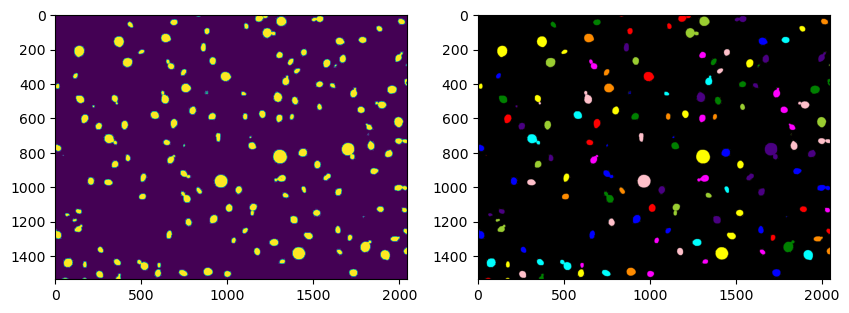

In [10]:
# Let's test those functions on one of our masked arrays

masked_image = mask_df["image"].iloc[0]  # grab the first masked array 

labeled_image = mask2labeled(masked_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (10,4))

ax1.imshow(labeled_image > 0)  # binary representing
ax2.imshow(skimage.color.label2rgb(labeled_image)) # each object colored a different color

In [12]:
# our labeled_properties_df function takes a labeled image as input
# and produces a DataFrame of the resulting properties, with each
# row representing an object

prop_df = labeled_properties_df(labeled_image)

prop_df.head()

,label,centroid-0,centroid-1,area,feret_diameter_max
0,1,6.202216,832.545706,361.0,37.013511
1,2,0.000000,828.000000,1.0,1.000000
2,3,0.000000,1231.000000,1.0,1.000000
3,4,0.333333,1234.000000,3.0,3.162278
4,5,1.500000,853.500000,2.0,2.236068


## Adding the properties DataFrames as columns in our higher level DataFrame

DataFrame can hold arbitrary Python objects, including other DataFrames!  Below we create a new column in `mask_df` to hold each of the property DataFrames corresponding to each masked image.

In [13]:
# add new columns for the labeled image arrays and the cell properties data frames

mask_df["labeled_img"] = [mask2labeled(i) for i in mask_df["image"]]
mask_df["cell_properties"] = [labeled_properties_df(i) for i in mask_df["labeled_img"]]

mask_df.head()

,strain,treatment,imgtype,rep,file,image,labeled_img,cell_properties
2,PMY2279,CONTROL,mask,A,PMY2279_CONTROL_A_mask.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label centroid-0 centroid-1 area ...
3,PMY2279,CONTROL,mask,B,PMY2279_CONTROL_B_mask.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label centroid-0 centroid-1 area ...
6,PMY2279,IBMX-2mM,mask,A,PMY2279_IBMX-2mM_A_mask.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label centroid-0 centroid-1 area ...
7,PMY2279,IBMX-2mM,mask,B,PMY2279_IBMX-2mM_B_mask.jpg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",label centroid-0 centroid-1 area fer...


Below we're going to combine all the cell properties data frames into one, so we'll add additional columns onto the sub-data frames so we can do grouping operations as appropriate after they've been combined.

In [19]:
for (i,row) in mask_df.iterrows():
    row["cell_properties"]["treatment"] = row["treatment"]
    row["cell_properties"]["rep"] = row["rep"]

In [20]:
# here's what one of these sub-DFs looks like now

mask_df["cell_properties"].iloc[0].head()

,label,centroid-0,centroid-1,area,feret_diameter_max,treatment,rep
0,1,6.202216,832.545706,361.0,37.013511,CONTROL,A
1,2,0.000000,828.000000,1.0,1.000000,CONTROL,A
2,3,0.000000,1231.000000,1.0,1.000000,CONTROL,A
3,4,0.333333,1234.000000,3.0,3.162278,CONTROL,A
4,5,1.500000,853.500000,2.0,2.236068,CONTROL,A


## Combining the cell properties sub-data frames

Now we're ready to combine the sub-DFs into one table of cell properties

In [21]:
cell_props = pd.concat(mask_df["cell_properties"].tolist(), ignore_index=True)

In [22]:
cell_props.shape

(6065, 7)

In [23]:
cell_props.head()

,label,centroid-0,centroid-1,area,feret_diameter_max,treatment,rep
0,1,6.202216,832.545706,361.0,37.013511,CONTROL,A
1,2,0.000000,828.000000,1.0,1.000000,CONTROL,A
2,3,0.000000,1231.000000,1.0,1.000000,CONTROL,A
3,4,0.333333,1234.000000,3.0,3.162278,CONTROL,A
4,5,1.500000,853.500000,2.0,2.236068,CONTROL,A


Notice that some of the objects of very small areas -- this represents noise or schmutz in the images. Before we proceeed, let's filter the cell properties table so we only consider objects with areas of at least 100 pixels.

In [25]:
# This greatly reduces the objects to consider

cell_filtered = cell_props[cell_props["area"] >= 100]
cell_filtered.shape

(354, 7)

Now we can group by and apply various computations and counts to group.s

In [51]:
cell_group = cell_filtered.groupby("treatment")
cell_group.groups.keys()

dict_keys(['CONTROL', 'IBMX-2mM'])

In [30]:
# Useful summary stats of the area property

cell_group["area"].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
CONTROL,304.0,1119.822368,754.819241,101.0,622.50,928.5,1412.25,5054.0
IBMX-2mM,50.0,4449.380000,3567.759234,105.0,1476.75,4043.5,5823.75,14523.0


In [29]:
# Useful summary stats of the feret diameter property

cell_group["feret_diameter_max"].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
CONTROL,304.0,45.175261,14.812860,14.764823,34.985711,41.880783,53.366634,103.942292
IBMX-2mM,50.0,87.517571,44.554423,14.317821,47.671436,83.586799,114.800874,210.090457


### Some summary plots

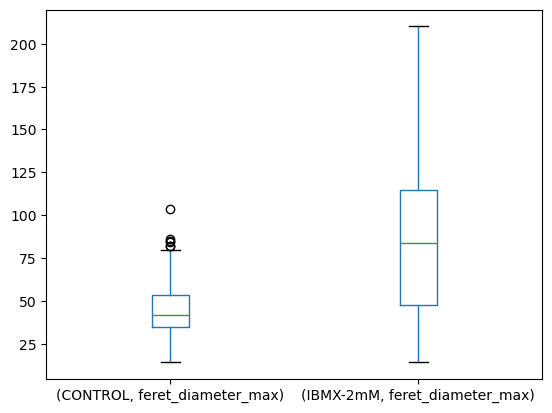

In [93]:
# Using pandas built-in plotting 

cell_group.boxplot(column="feret_diameter_max",
                  subplots = False,
                  grid = False,
                  )
pass

## Fancier plots with seaborn

If you have the seaborn packaged installed it's easy to make nicer plots.

In [70]:
import seaborn as sns

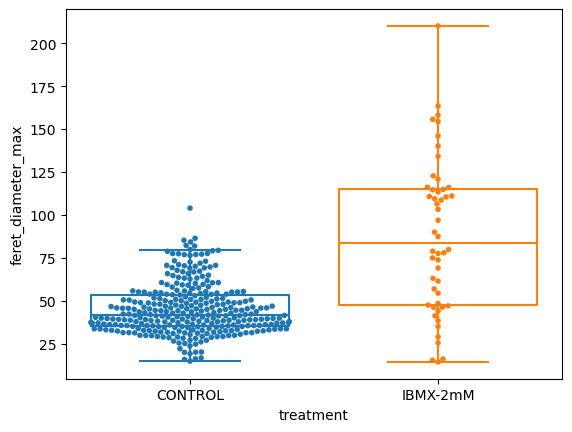

In [122]:
# boxplot plus swarmplots

sns.boxplot(x="treatment", y="feret_diameter_max", data=cell_filtered,
           hue = "treatment", fill = False, showfliers=False)
sns.swarmplot(x="treatment", y="feret_diameter_max", data=cell_filtered,
             size = 4, hue = "treatment")
pass

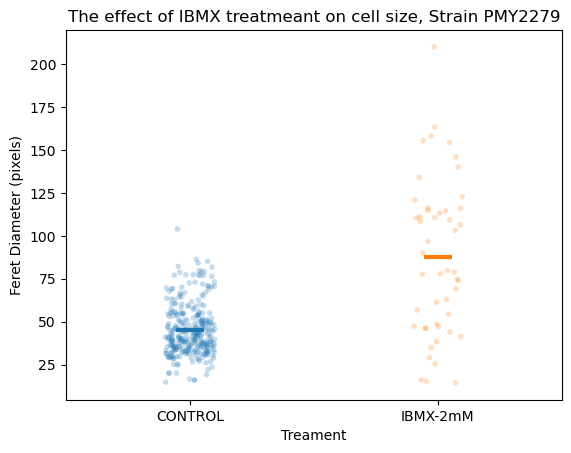

In [126]:
# alternate representation using strip plots
# and pointplots (to draw lines representing means)

ax = sns.stripplot(x="treatment", y="feret_diameter_max", data=cell_filtered,
             size = 4, hue = "treatment", alpha = 0.25)

sns.pointplot(x="treatment",
                y="feret_diameter_max",
                data=cell_filtered,
                hue = "treatment",
                errorbar=None,
                marker="_", 
                markersize=20, 
                markeredgewidth=3,
                estimator='mean',
             )

plt.xlabel("Treament")
plt.ylabel("Feret Diameter (pixels)")
plt.title("The effect of IBMX treatmeant on cell size, Strain PMY2279")

# showing how to save figure as high resolution PNG
plt.savefig("example_figure.png", dpi=600)
pass